
# Multi‑Output Regression with TensorFlow/Keras (4‑response)

68 LENSPMD25 INFORME-OM4M007 medida spatial freqs using ML

This notebook trains a fully‑connected neural network to predict **four continuous responses** (e.g., `['w','wx','wy','theta']`) from tabular predictors.  
It mirrors the typical MATLAB `fitrnet` pipeline (train/val/test split, evaluation plots) and **saves a model** for later inference.

**Conda enviroment:**

run conda activate LENSPMD25-base310 

if not present create enviroment using yml file

**Artifacts produced:**

- TensorFlow SavedModel at `local_data/ML_models/trainedModel_"date"_"feture_name"_"DB_name".keras`
- Fitted `StandardScaler` at `local_data/ML_models/scaler_"date"_"feature_name"_"DB_name".pkl`
- `feature_metadata.json` at 'feature_metadata__"date"_"feture_name"_"DB_name".json' with predictor/response names
- Inference helper `predict_tf.py` (also provided separately) for later use


In [1]:
# ---
# ✅ Colab bootstrap for LensPMD
# How to open in Colab:
# 1) Clone the LensPMD repo into Google Drive.
# 2) In Drive (web), right-click the notebook → “Open with” → “Google Colab”.
# 3) Run this cell to mount Drive, set the working directory, and verify required paths.
# ---

import os
from pathlib import Path

# === Detect Colab =============================================================
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

print(f"Running in Colab? {IN_COLAB}")

# === Setup when in Colab ======================================================
if IN_COLAB:
    from google.colab import drive  # type: ignore
    DRIVE_MOUNT_POINT = "/content/drive"
    PROJECT_REL_PATH = "MyDrive/Colab Notebooks/68_LensPMD25_INFORME-OM4M007/Python_src"
    REQUIRED_PATH = "/content/drive/MyDrive/Colab Notebooks/68_LensPMD25_INFORME-OM4M007/local_data"

    # Mount Google Drive
    drive.mount(DRIVE_MOUNT_POINT, force_remount=True)

    # Set working directory
    project_path = Path(DRIVE_MOUNT_POINT) / PROJECT_REL_PATH
    if not project_path.exists():
        raise FileNotFoundError(f"❌ Project directory not found: {project_path}")

    os.chdir(project_path)
    print("✅ Working Directory:", Path.cwd())

    # Verify required local_data folder exists
    local_data_path = Path(REQUIRED_PATH)
    if not local_data_path.exists():
        raise FileNotFoundError(
            f"❌ Required directory not found: {local_data_path}\n"
            "Please ensure 'local_data' exists in the LensPMD folder in your Drive."
        )

    print("✅ Required folder found:", local_data_path)
    print("📂 Files in Working Directory:", os.listdir())

else:
    print("Not running in Colab — skipping Drive mount and WD setup.")
    print("Current Working Directory:", Path.cwd())


Running in Colab? False
Not running in Colab — skipping Drive mount and WD setup.
Current Working Directory: c:\user\AQ_SCC\68_LensPMD25_INFORME-OM4M007\Python_src


In [ ]:

# --- Setup & configuration ---
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If TensorFlow is not installed in your environment, install it first.
# %pip install tensorflow==2.16.* scikit-learn==1.4.* pandas matplotlib openpyxl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pathlib import Path

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers, callbacks # type: ignore

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---- Data sources ----
# Root folder where your Excel files live
rootFolderDB = Path('../local_data/ML_Models')  # adjust as needed
trainingSetsDBName = 'DB-trainingSets-OM4M007.xlsx'

# Choose which row to use (mirrors MATLAB 'trainingSet_Idx')
trainingSet_Idx = 16  # 1-based index in your Excel sheet; adjust

# If you do NOT use the DB Excel indirection, set featureDBFileName directly:
# featureDBFileName = 'DB_feature_projected_DFT_13x13_GVN-0_NS-15000_28-Aug-2025.xlsx'
# In that case, set `USE_DB_INDEX` to False.
USE_DB_INDEX = True

# Which sheet, and names to exclude from predictors (mirrors provided MATLAB logic)
excel_sheet = 'Sheet1'
nameList2Exclude = ['w','wx','wy','theta', 'fringe_bkgrd', 'fringe_mod']

# Response variables (4‑response setup)
responseNameList = ['w','wx','wy','theta']

# Model hyperparameters (similar to fitrnet layer sizes)
hidden_layers = [50, 50, 50, 50]
activation = 'relu'
batch_size = 1024
max_epochs = 200
learning_rate = 1e-3
early_stop_patience = 15

# Output paths
# artifacts_dir = Path('../ML_Models')
# artifacts_dir.mkdir(parents=True, exist_ok=True)
# saved_model_file = artifacts_dir / 'trainedModel.keras'
# scaler_path = artifacts_dir / 'scaler.pkl'
# meta_path = artifacts_dir / 'feature_metadata.json'

print('TensorFlow version:', tf.__version__)
# print('Artifacts will be saved to:', artifacts_dir.resolve())


TensorFlow version: 2.16.2


In [3]:
# --- Resolve data file to load ---
if USE_DB_INDEX:
    db_path = rootFolderDB / trainingSetsDBName
    print('Reading trainingSets DB from:', db_path.resolve())
    trainingSetsTb = pd.read_excel(db_path, sheet_name=excel_sheet)
    # Convert to zero-based index
    row_idx = trainingSet_Idx - 1
    assert 0 <= row_idx < len(trainingSetsTb), 'trainingSet_Idx out of range.'
    featureDBFileName = trainingSetsTb.loc[row_idx, 'featureDBFileName']
    print('featureDBFileName selected:', featureDBFileName)
else:
    assert 'featureDBFileName' in globals(), 'Set featureDBFileName if USE_DB_INDEX is False'

fileDB = rootFolderDB / featureDBFileName
print('Reading feature DB from:', fileDB.resolve())
dataTb = pd.read_excel(fileDB)
print('dataTb shape:', dataTb.shape)


Reading trainingSets DB from: C:\user\AQ_SCC\68_LensPMD25_INFORME-OM4M007\local_data\ML_Models\DB-trainingSets-OM4M007.xlsx
featureDBFileName selected: DB_feature_projected_DFT_15x15_GVN-0_NS-16001_13-Oct-2025.xlsx
Reading feature DB from: C:\user\AQ_SCC\68_LensPMD25_INFORME-OM4M007\local_data\ML_Models\DB_feature_projected_DFT_15x15_GVN-0_NS-16001_13-Oct-2025.xlsx
dataTb shape: (16001, 29)


In [4]:
# --- Output paths for artifacts with date + featureDBFileName suffix ---

from datetime import datetime
import re
from pathlib import Path

artifacts_dir = rootFolderDB
artifacts_dir.mkdir(parents=True, exist_ok=True)

def sanitize_for_fs(text: str) -> str:
    """
    Keep letters, digits, dot, dash, underscore; collapse repeats; strip ends.
    Useful for Windows-safe filenames.
    """
    s = re.sub(r'[^A-Za-z0-9._-]+', '_', str(text))
    s = re.sub(r'_{2,}', '_', s).strip('_')
    return s

# 1) Timestamp valid for filenames (no ':' etc.)
date_tag = datetime.now().strftime('%d-%m-%Y')   # <-- only date

# 2) Tag from the feature DB name (stem, no extension), sanitized
feat_tag = sanitize_for_fs(Path(featureDBFileName).stem)

# 3) Suffix and final artifact paths
suffix = f"{date_tag}_{feat_tag}"

saved_model_file = artifacts_dir / f"trainedModel_{suffix}.keras"
scaler_path      = artifacts_dir / f"scaler_{suffix}.pkl"
meta_path        = artifacts_dir / f"feature_metadata_{suffix}.json"

print("Artifacts:")
print("  model:", saved_model_file.resolve())
print("  scaler:", scaler_path.resolve())
print("  meta:", meta_path.resolve())

Artifacts:
  model: C:\user\AQ_SCC\68_LensPMD25_INFORME-OM4M007\local_data\ML_Models\trainedModel_14-10-2025_DB_feature_projected_DFT_15x15_GVN-0_NS-16001_13-Oct-2025.keras
  scaler: C:\user\AQ_SCC\68_LensPMD25_INFORME-OM4M007\local_data\ML_Models\scaler_14-10-2025_DB_feature_projected_DFT_15x15_GVN-0_NS-16001_13-Oct-2025.pkl
  meta: C:\user\AQ_SCC\68_LensPMD25_INFORME-OM4M007\local_data\ML_Models\feature_metadata_14-10-2025_DB_feature_projected_DFT_15x15_GVN-0_NS-16001_13-Oct-2025.json


In [5]:

# --- Build predictor/response matrices ---
all_vars = list(dataTb.columns)
predictorNameList = [v for v in all_vars if v not in nameList2Exclude]
missingPredictors = [v for v in predictorNameList if v not in all_vars]
if missingPredictors:
    raise ValueError(f'Missing predictors in table: {missingPredictors}')

for resp in responseNameList:
    if resp not in all_vars:
        raise ValueError(f'Response variable {resp} not found in table.')

X = dataTb[predictorNameList].copy()
Y = dataTb[responseNameList].copy()

# Drop rows with any missing values in X or Y
valid_mask = (~X.isna().any(axis=1)) & (~Y.isna().any(axis=1))
X = X.loc[valid_mask].reset_index(drop=True)
Y = Y.loc[valid_mask].reset_index(drop=True)

print('After dropping missing: X:', X.shape, 'Y:', Y.shape)


After dropping missing: X: (16001, 23) Y: (16001, 4)


In [6]:

# --- Three-way split: Train (~70%), Val (15%), Test (15%) ---
# First take 15% as test
X_notTest, X_test, Y_notTest, Y_test = train_test_split(
    X, Y, test_size=0.15, random_state=SEED, shuffle=True
)

# From remaining 85%, carve out ~15% total as validation (i.e., 15/85 ≈ 0.176 of remainder)
val_fraction_of_remainder = 0.15 / 0.85  # ~0.176
X_train, X_val, Y_train, Y_val = train_test_split(
    X_notTest, Y_notTest, test_size=val_fraction_of_remainder, random_state=SEED, shuffle=True
)

print(f'Split sizes — Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}')


Split sizes — Train: 11200, Val: 2400, Test: 2401


In [7]:

# --- Standardize predictors based on TRAIN only ---
from pathlib import Path
import pickle

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train.values)
X_val_std   = scaler.transform(X_val.values)
X_test_std  = scaler.transform(X_test.values)

# Targets as float32 arrays
Y_train_np = Y_train.values.astype('float32')
Y_val_np   = Y_val.values.astype('float32')
Y_test_np  = Y_test.values.astype('float32')

# Save scaler and metadata
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

meta = {
    "predictorNameList": predictorNameList,
    "responseNameList": responseNameList
}
with open(meta_path, 'w', encoding='utf-8') as f:
    json.dump(meta, f, indent=2)

print('Saved scaler to:', scaler_path.resolve())
print('Saved metadata to:', meta_path.resolve())


Saved scaler to: C:\user\AQ_SCC\68_LensPMD25_INFORME-OM4M007\local_data\ML_Models\scaler_14-10-2025_DB_feature_projected_DFT_15x15_GVN-0_NS-16001_13-Oct-2025.pkl
Saved metadata to: C:\user\AQ_SCC\68_LensPMD25_INFORME-OM4M007\local_data\ML_Models\feature_metadata_14-10-2025_DB_feature_projected_DFT_15x15_GVN-0_NS-16001_13-Oct-2025.json


In [8]:

# --- tf.data pipelines ---
train_ds = tf.data.Dataset.from_tensor_slices((X_train_std, Y_train_np)).shuffle(10000, seed=SEED).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val_std, Y_val_np)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_std, Y_test_np)).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [9]:

# --- Define multi-output regression MLP ---
def build_model(input_dim, hidden_sizes, activation='relu', outputs=4):
    inputs = keras.Input(shape=(input_dim,), name='features')
    x = inputs
    for i, h in enumerate(hidden_sizes):
        x = layers.Dense(h, activation=activation, name=f'dense_{i+1}')(x)
    # Linear output layer for regression with 4 responses
    out = layers.Dense(outputs, activation='linear', name='responses')(x)
    model = keras.Model(inputs=inputs, outputs=out, name='mlp_multioutput_regressor')
    return model

model = build_model(input_dim=X_train_std.shape[1],
                    hidden_sizes=hidden_layers,
                    activation=activation,
                    outputs=Y_train_np.shape[1])

model.summary()


Model: "mlp_multioutput_regressor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ responses (Dense)               │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,054 (35.37 KB)

 Trainable params: 9,054 (35.37 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:

# --- Compile & Train ---
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# For multi-output regression, use MSE loss; track RMSE metric post-hoc.
model.compile(optimizer=optimizer, loss='mse')

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_patience, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint(
    filepath=saved_model_file.as_posix(), # <-- must end with .keras
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min'
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=max_epochs,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# The best model is saved at `saved_model_file` thanks to ModelCheckpoint.
print('Best model will be saved to:', saved_model_file.resolve())


Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.1104 - val_loss: 0.6868
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5650 - val_loss: 0.4016
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2834 - val_loss: 0.1625
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1252 - val_loss: 0.0979
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0802 - val_loss: 0.0653
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0571 - val_loss: 0.0498
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0439 - val_loss: 0.0405
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0364 - val_loss: 0.0339
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0312 - val_loss: 0.0296
Epoch 10/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0277 - val_loss: 0.0266
Epoch 11/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0251 - val_loss: 0.0242
Epoch 12/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

In [11]:

# --- Evaluate ---
def rmse_per_dim(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2, axis=0))  # per-dimension RMSE

Y_val_pred  = model.predict(val_ds)
Y_test_pred = model.predict(test_ds)

val_rmse_per_resp  = rmse_per_dim(Y_val_np,  Y_val_pred)
test_rmse_per_resp = rmse_per_dim(Y_test_np, Y_test_pred)

val_rmse_all  = float(np.sqrt(np.mean((Y_val_np  - Y_val_pred)  ** 2)))
test_rmse_all = float(np.sqrt(np.mean((Y_test_np - Y_test_pred) ** 2)))

print('Validation RMSE per response:', dict(zip(responseNameList, val_rmse_per_resp)))
print('Validation RMSE (all):', val_rmse_all)
print('Test RMSE per response:', dict(zip(responseNameList, test_rmse_per_resp)))
print('Test RMSE (all):', test_rmse_all)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Validation RMSE per response: {'w': 0.03364717, 'wx': 0.03488372, 'wy': 0.031560607, 'theta': 0.028472591}
Validation RMSE (all): 0.032232616096735
Test RMSE per response: {'w': 0.033696692, 'wx': 0.033159304, 'wy': 0.03452738, 'theta': 0.03173875}
Test RMSE (all): 0.03329598903656006


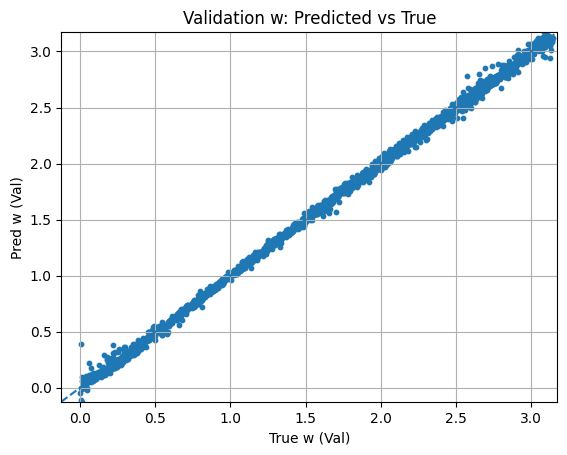

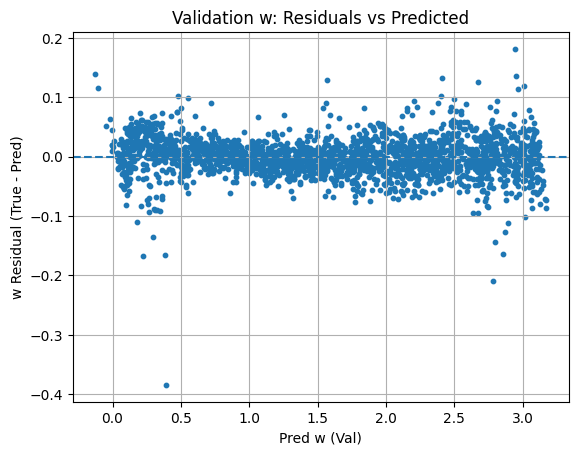

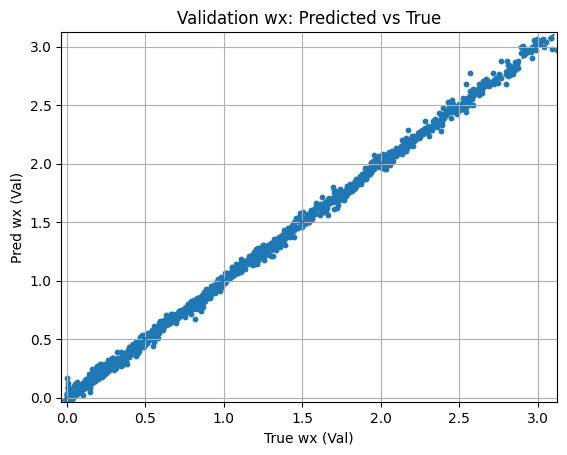

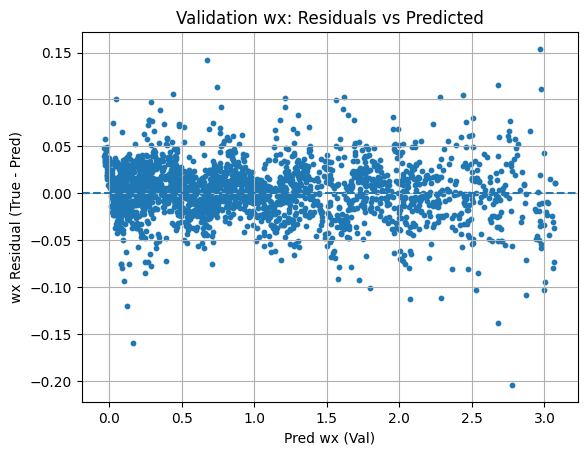

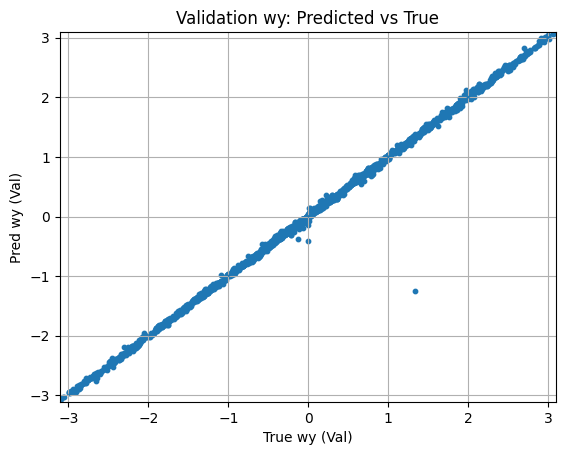

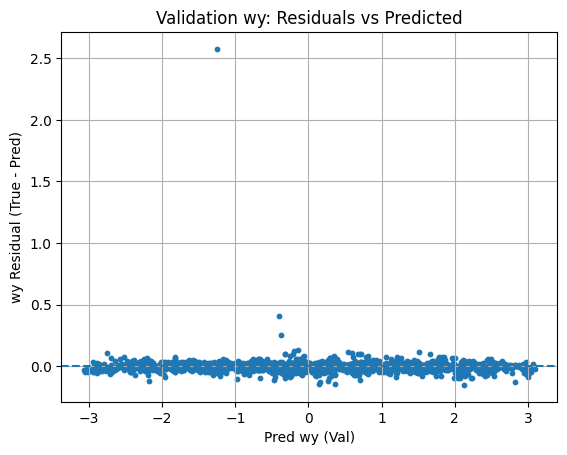

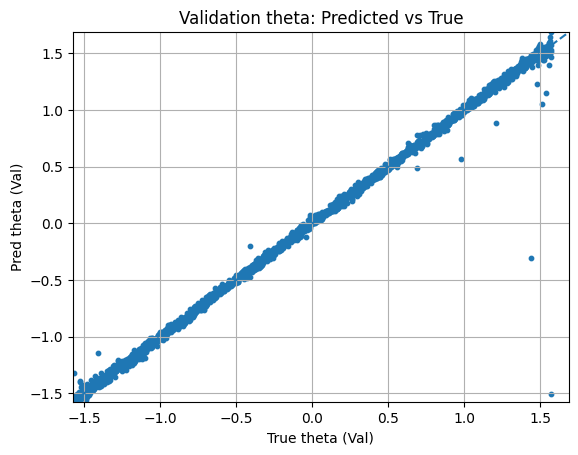

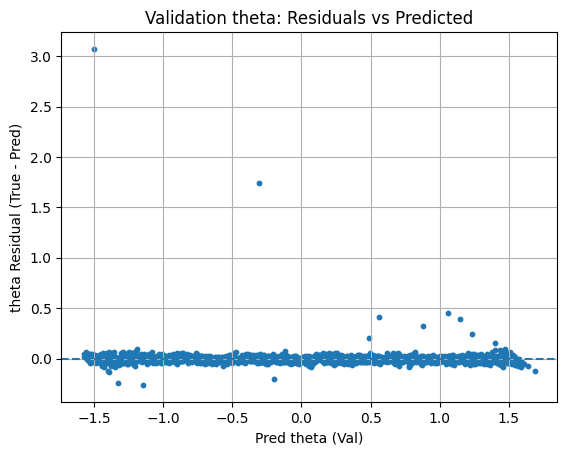

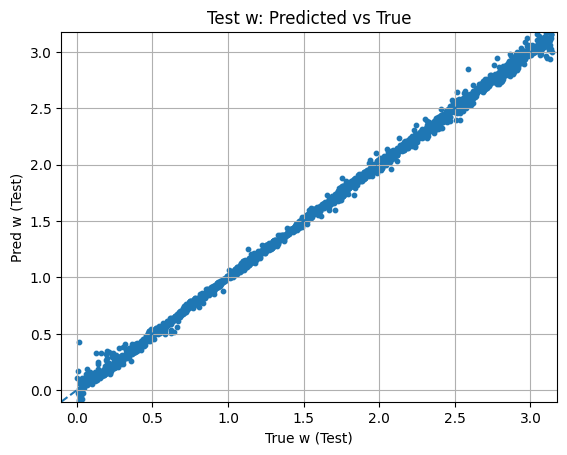

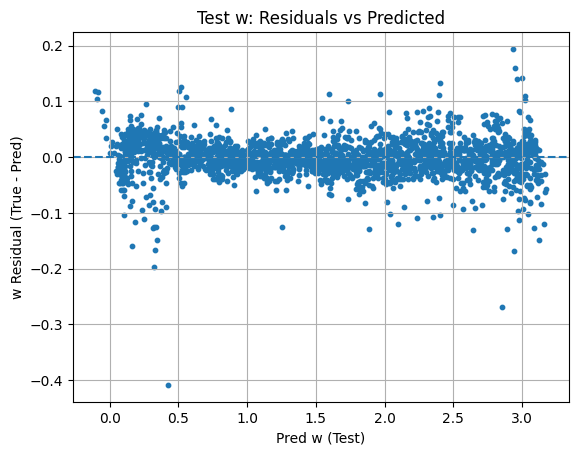

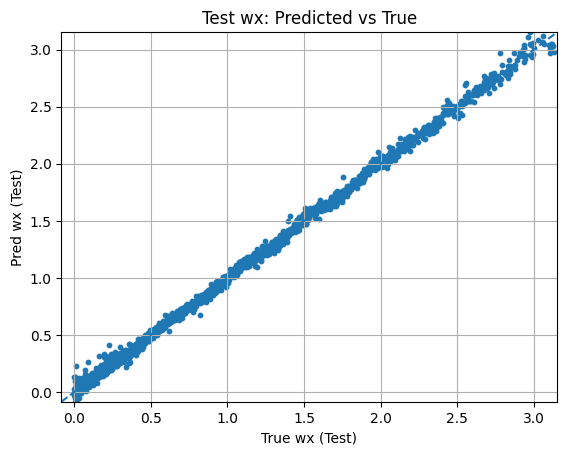

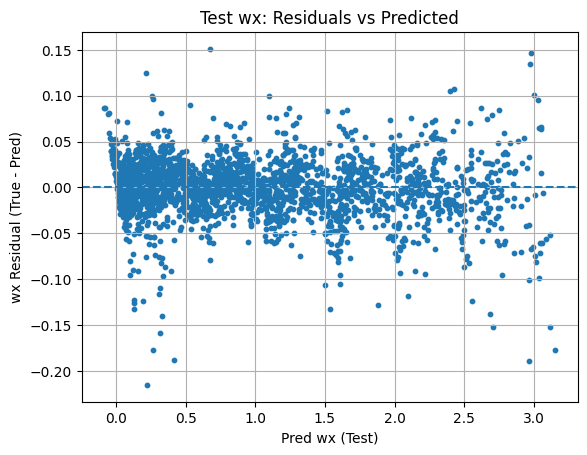

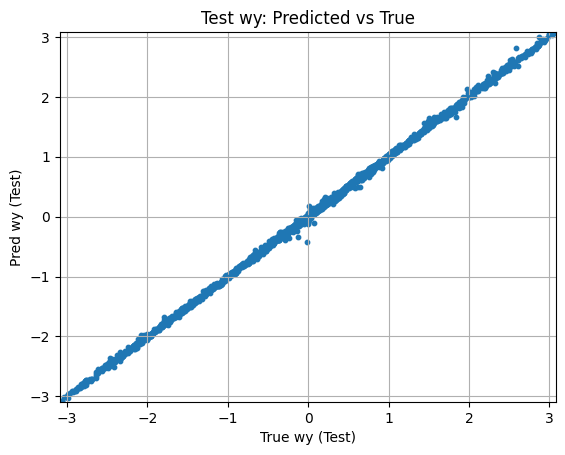

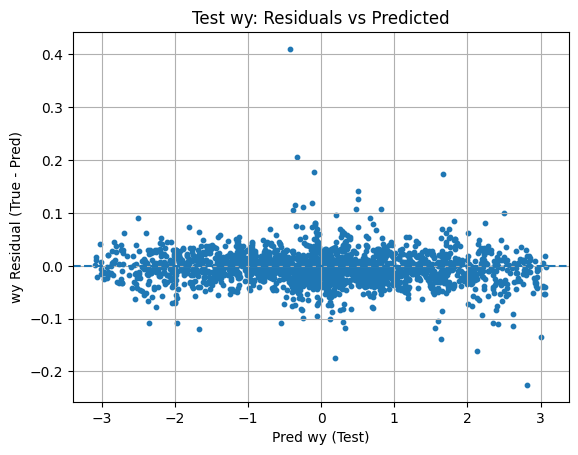

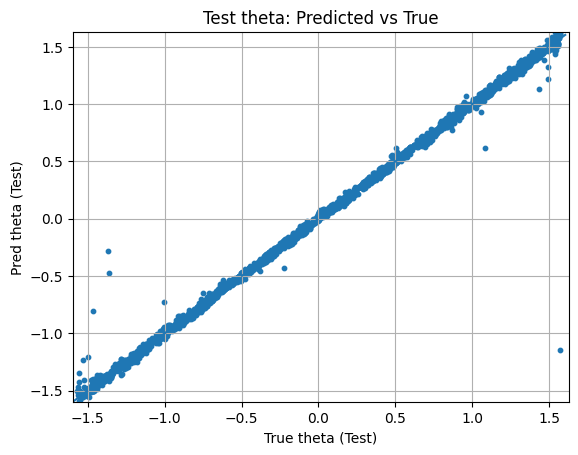

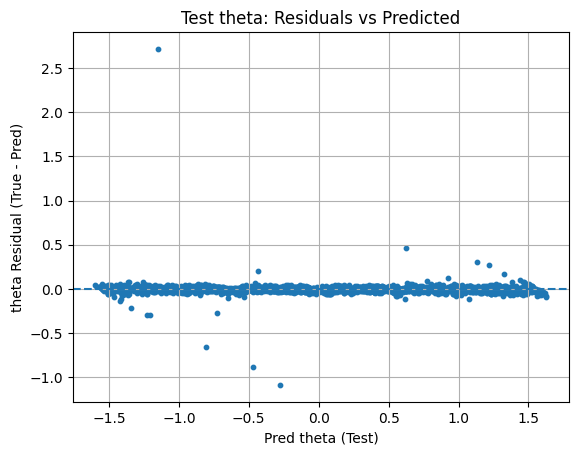

In [13]:

# --- Plots ---
# Use matplotlib, one chart per figure, no explicit colors.
for i, resp in enumerate(responseNameList):
    # Validation: Pred vs True
    plt.figure()
    plt.scatter(Y_val_np[:, i], Y_val_pred[:, i], s=10)
    plt.grid(True)
    lims = [min(Y_val_np[:, i].min(), Y_val_pred[:, i].min()), max(Y_val_np[:, i].max(), Y_val_pred[:, i].max())]
    plt.plot(lims, lims, '--')
    plt.xlim(lims); plt.ylim(lims)
    plt.xlabel(f'True {resp} (Val)')
    plt.ylabel(f'Pred {resp} (Val)')
    plt.title(f'Validation {resp}: Predicted vs True')
    plt.show()

    # Validation: Residuals
    plt.figure()
    val_resid = Y_val_np[:, i] - Y_val_pred[:, i]
    plt.scatter(Y_val_pred[:, i], val_resid, s=10)
    plt.axhline(0, linestyle='--')
    plt.grid(True)
    plt.xlabel(f'Pred {resp} (Val)')
    plt.ylabel(f'{resp} Residual (True - Pred)')
    plt.title(f'Validation {resp}: Residuals vs Predicted')
    plt.show()

for i, resp in enumerate(responseNameList):
    # Test: Pred vs True
    plt.figure()
    plt.scatter(Y_test_np[:, i], Y_test_pred[:, i], s=10)
    plt.grid(True)
    lims = [min(Y_test_np[:, i].min(), Y_test_pred[:, i].min()), max(Y_test_np[:, i].max(), Y_test_pred[:, i].max())]
    plt.plot(lims, lims, '--')
    plt.xlim(lims); plt.ylim(lims)
    plt.xlabel(f'True {resp} (Test)')
    plt.ylabel(f'Pred {resp} (Test)')
    plt.title(f'Test {resp}: Predicted vs True')
    plt.show()

    # Test: Residuals
    plt.figure()
    test_resid = Y_test_np[:, i] - Y_test_pred[:, i]
    plt.scatter(Y_test_pred[:, i], test_resid, s=10)
    plt.axhline(0, linestyle='--')
    plt.grid(True)
    plt.xlabel(f'Pred {resp} (Test)')
    plt.ylabel(f'{resp} Residual (True - Pred)')
    plt.title(f'Test {resp}: Residuals vs Predicted')
    plt.show()


In [13]:

# --- Save final model (again) & quick demo ---
model.save(saved_model_file.as_posix(), include_optimizer=False)
print('Model saved (SavedModel) to:', saved_model_file.resolve())

# Quick inference demo on standardized test rows
sample = X_test_std[:5]
pred = model.predict(sample)
print('Sample predictions shape:', pred.shape)
print('First row prediction [w, wx, wy, theta]:', pred[0])


Model saved (SavedModel) to: C:\user\AQ_SCC\68_LensPMD25_INFORME-OM4M007\local_data\ML_Models\trainedModel_14-10-2025_DB_feature_projected_DFT_15x15_GVN-0_NS-16001_13-Oct-2025.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Sample predictions shape: (5, 4)
First row prediction [w, wx, wy, theta]: [ 1.5873284   1.551304   -0.30214238 -0.20001477]


In [14]:

# --- Standalone inference helper within the notebook ---
import pickle

def load_artifacts(model_file=saved_model_file, scaler_pkl=scaler_path, meta_json=meta_path):
    model = keras.models.load_model(model_file.as_posix())
    with open(scaler_pkl, 'rb') as f:
        scaler = pickle.load(f)
    with open(meta_json, 'r', encoding='utf-8') as f:
        meta = json.load(f)
    return model, scaler, meta

def predict_from_dataframe(df, model_file=saved_model_file, scaler_pkl=scaler_path, meta_json=meta_path):
    model, scaler, meta = load_artifacts(model_file, scaler_pkl, meta_json)
    req_vars = meta['predictorNameList']
    missing = [v for v in req_vars if v not in df.columns]
    if missing:
        raise ValueError(f'Missing required predictor(s): {missing}')
    X = df[req_vars].values
    X_std = scaler.transform(X)
    y_pred = model.predict(X_std)
    return pd.DataFrame(y_pred, columns=meta['responseNameList'])

# Example (commented):
df_new = pd.DataFrame(X_test, columns=predictorNameList).iloc[:3]
yhat = predict_from_dataframe(df_new)
yhat


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


,w,wx,wy,theta
0,1.587328,1.551304,-0.302142,-0.200015
1,3.136825,2.991433,0.957376,0.341936
2,3.038355,2.476017,-1.748204,-0.586576


In [16]:
# for predict from aux file predict_tf
# from predict_tf import predict_from_dataframe

# yhat = predict_from_dataframe(
#     df_new,
#     model_path="models/trainedModel_20251007_103200_DB_feature_projected_DFT_13x13_GVN-0_NS-15000.keras",
#     scaler_pkl="models/scaler_20251007_103200_DB_feature_projected_DFT_13x13_GVN-0_NS-15000.pkl",
#     meta_json="models/feature_metadata_20251007_103200_DB_feature_projected_DFT_13x13_GVN-0_NS-15000.json",
# )


## Optional: 5‑Fold Cross‑Validation (Stub)

To mirror a manual K‑fold CV, loop over `sklearn.model_selection.KFold`, rebuild and fit the model on each train split, and compute per‑fold RMSE per response. Omitted for brevity.
